In [469]:
# MAKEMORE TUTORIAL
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import random
import pandas as pd
import re
import string


from prettytable import PrettyTable

In [310]:
import urllib.request, json 
with urllib.request.urlopen("https://raw.githubusercontent.com/taivop/joke-dataset/master/wocka.json") as url:
    raw_json = json.load(url)

all_jokes = pd.json_normalize(raw_json)

In [311]:
one_liners = all_jokes[all_jokes.category=='One Liners']

In [465]:
jokes = [j.lower() for j in one_liners.body]


remove = [
    [j for j in jokes if 'ã' in j][0],
    [j for j in jokes if '~' in j][0],
]
for r in remove: jokes.remove(r)


In [560]:
cleaned_jokes = []
printable = set(string.printable)

for j in jokes: #[j for j in jokes if "42" or "tail" in j]:
    # j = j.replace("\r\n", "<temp>")
    # j = j.split("<temp>")
    # cleaned_jokes.append(j)
    lines = j.splitlines()
    for l in lines:
        l = l.replace('"', "").replace("'", "") ##remove quotations
        l = ''.join(filter(lambda x: x in printable, l)) ##remove non "printable" chars
        l = l.replace(".", "")


        if (l=='') | (l==' ') | (l=='  ') | len(l) < 30:
            pass
        else:
            cleaned_jokes.append(l)

    
    ## not perfect strategy since the text has inconsistent \r\n behavior - some jokes are cut into pieces

    # print(j)
    # joke_split = re.split(r"[~\r\n]+", j)
    # for s in joke_split: cleaned_jokes.append(s)
    # if char[0] == '': char[0] =  ' '
    # joke += char[0]
    # cleaned_jokes.append(joke)

    # for j in line.splitlines():
    #     if (j=='') | (len(j) < 40) | (j==' ') | (j=='  '):
    #         pass
    #     else:
    # #         temp += j + ' '    
    #         cleaned_jokes.append(j)  

In [566]:
chars = sorted(list(set(''.join(cleaned_jokes)))) 

len(chars)

59

In [567]:
stoi = {s:i+1 for i, s in enumerate(chars)} ##create dictionary mapping from char to int
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

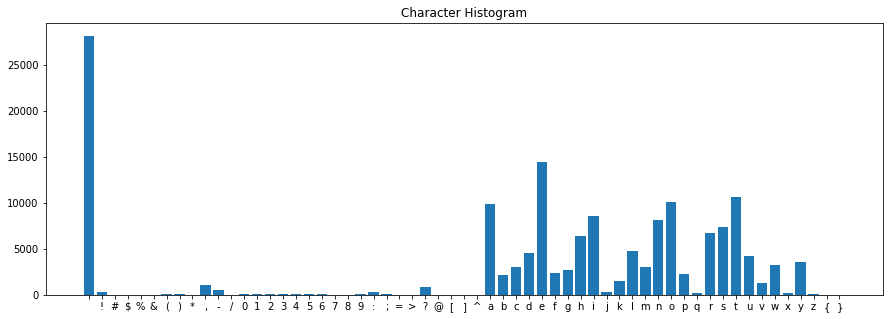

In [568]:
corpus = ''.join(cleaned_jokes)
count_letters = dict()

for c in chars:
    count_letters[c] = corpus.count(c)

plt.figure(figsize=(15,5))
plt.bar(range(len(count_letters)), list(count_letters.values()), align='center')
plt.xticks(range(len(count_letters)), list(count_letters.keys()))
plt.title("Character Histogram")
plt.show()

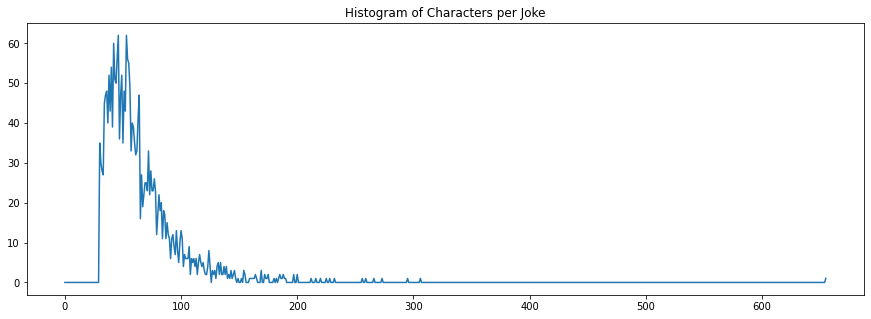

In [569]:
joke_length = {k: 0 for k in range(len(max(cleaned_jokes, key=len))+1)}
for j in cleaned_jokes:
    joke_length[len(j)] += 1

plt.figure(figsize=(15,5))
plt.plot(list(joke_length.keys()), list(joke_length.values()))    
plt.title("Histogram of Characters per Joke")
plt.show()

In [570]:
data = [j for j in cleaned_jokes if len(j) < 101]
len(data)

2163

In [571]:
data[:5]

['if the opposite of pro is con, isnt the opposite of progress, congress?',
 'there was a dyslexic insomniac agnostic',
 'he laid awake all night wondering if there really was a dog',
 'do infants enjoy infancy as much as adults enjoy adultery?',
 'if a pig loses its voice, is it disgruntled?']

In [574]:
n_out = 3
sample = "hello good sir"
for ci in range(len(sample)):
    if ci in range(len(sample)-n_out, len(sample)):
        print(sample[ci])

s
i
r


In [ ]:
# so you feed in ~50 characters (one-hot encoded vectors) and want the model to spit out like the next 50 chars, but that means having 50 different
# output nodes all completely unrelated to each other - so need to figure out how to configure the ys

In [584]:
def create_joke_data(jokes, n_in, n_out, characters):
    """
    Takes words list and breaks into training samples based on the desired model-type. For example,
    a bigram model where n=2 or a trigram model where n=3. 
    Returns xs and ys (inputs and labels).
    """
    stoi = {s:i+1 for i, s in enumerate(characters)} ##create dictionary mapping from char to int
    stoi['.'] = 0
    itos = {i:s for s, i in stoi.items()}   
    n = n_in + n_out
    xs = []
    ys = []

    for w in jokes:
        chs = ['.'] + list(w) + ['.']  ##special start and end characters
        if len(chs) < n:
            fill = n - len(chs)
            chs = chs + list('.' for _ in range(fill))
        for sample_list in zip(chs[i : i+n] for i in range(len(chs)-(n-1))):
            for s in range(len(sample_list)):
                sample = sample_list[s]
                temp_x, temp_y = [], []
                for ci in range(len(sample)):
                    if ci in range(len(sample)-n_out, len(sample)):
                        temp_y.append(stoi[sample[ci]])
                    else:
                        temp_x.append(stoi[sample[ci]])
                xs.append(temp_x)
                ys.append(temp_y)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    n_samples = xs.shape[0]
    print(f"number of samples: {n_samples}")

    return xs, ys


xs, ys = create_joke_data(data[:5], 50, 50, chars)

number of samples: 5


In [586]:

def split_samples(inputs, labels, frac=0.8, seed=123):
    "Split xs and ys (inputs and labels) into train and test sets"
    
    assert len(inputs)==len(labels), f"{len(inputs) = } which does not match {len(labels) = }"
    # generate a list of indices to exclude. Turn in into a set for O(1) lookup time
    random.seed(seed)
    indx = list(set(random.sample(list(range(len(inputs))), int(frac*len(inputs)))))

    x_mask = torch.zeros((len(inputs)), dtype=torch.bool) #False
    x_mask[indx] = True

    y_mask = torch.zeros((len(inputs)), dtype=torch.bool) #False
    y_mask[indx] = True

    train_x = inputs[x_mask]
    train_y = labels[y_mask]

    test_x = inputs[~x_mask]
    test_y = labels[~y_mask]

    return train_x, train_y, test_x, test_y

train_x, train_y, test_x, test_y = split_samples(xs, ys)
print(train_x.shape)
print(train_y.shape)

torch.Size([4, 50])
torch.Size([4, 50])


In [ ]:
class joke_gram:
    "An instance of an N-gram model where 'n' defines the number of characters used in the process."
    def __init__(self, n_in, n_out, characters):

        self.n_chars = len(characters)
        self.n_inputs = n_in ##the number of inputs (ie, excluding the label)
        self.n_outputs = n_out
        
        self.stoi = {s:i+1 for i, s in enumerate(characters)} ##create dictionary mapping from char to int
        self.stoi['.'] = 0 ##just one special character for start and end of word
        self.itos = {i:s for s, i in self.stoi.items()}

    def initialize_weights(self, generator, first_letter_neurons=False, xs=None):
        "Randomly initialize the model's weights."
        self.first_letter_neurons = first_letter_neurons

        # INITALIZE NETWORK WEIGHTS
        n_inputs = self.n_inputs
        n_chars = self.n_chars
        if xs is not None:
            assert n_inputs == xs.shape[1], f"n_inputs ({n_inputs}) does not match the xs.shape[1]"

        W_list = []
        for _ in range(n_inputs):
            W_list.append(torch.randn(size=(n_chars, n_chars), generator=generator, requires_grad=True))

        if first_letter_neurons:
            W_list.append(torch.randn(size=(n_chars, 1), generator=generator, requires_grad=True))
            # kind of like adding bias but only for the first character..?
        self.W_list = W_list
    

    def forward_pass(self, xs, ys=None, regularization=0):
        "Perform a forward pass of the inputs (xs) through the network. If ys are provided, loss will be evaluated."
        n_samples = xs.shape[0]
        n_inputs = self.n_inputs
        n_chars = self.n_chars
        W_list = self.W_list

        # forward pass
        ## calculate logits
        logits = torch.zeros((n_samples, n_chars))
        for ix in range(n_inputs):
            Wi = W_list[ix]
            xi_enc = F.one_hot(xs[:, ix], num_classes=n_chars).float()
            logits += (xi_enc @ Wi)
        if self.first_letter_neurons: ##if including weights on first letter neuron, they are the last in W list
            x1_enc = F.one_hot(xs[:, 0], num_classes=n_chars).float()
            logits += (x1_enc @ W_list[-1]) 

        ##Softmax
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdims=True)
        self.probs = probs

        ##loss
        if ys is not None:
            loss = -probs[torch.arange(n_samples), ys].log().mean()
            for W in W_list:
                loss += regularization*(W**2).mean()
            self.loss = loss
        
            return probs, loss
        else:
             return probs
                

    def backprop_update(self, lr=0.1):
        "Gradient descent - backpropogate the network and apply a fraction of the gradients to the current weights."
        # backward pass
        for W in self.W_list:
            W.grad = None
        self.loss.backward()

        # update params
        for W in self.W_list:
            W.data += -lr * W.grad ##learning rate


    def generate_words(self, n_words, start_chrs: str = None, min_length=0):
        """
        Generates n_words word examples by passing n-1 random characters into the model, performing a forward pass,
        and probabilistically choosing a character using the model's predicted probability distribution.
        Pass n-2 start_chrs to specify the starting characters of the word generation process (first character is always '.').
        Specify a minimum word length min_length to generate words at least that long.
        """
        itos = self.itos
        stoi = self.stoi
        
        n_inputs = self.n_inputs
        out_words = []

        for _ in range(n_words):
            ixlist = [0] 
            word = '.'
            if start_chrs is not None:
                assert len(start_chrs) == n_inputs-1, f"len(start) ({len(start_chrs)}) should be {n_inputs - 1 = }"
                for s in start_chrs:
                    word += s
                    ixlist.append(stoi[s])
            else:
                for ix in range(n_inputs-1):
                    ch_int = torch.randint(1, 26, (1,1), generator=g).item()
                    word += itos[ch_int]
                    ixlist.append(ch_int)

            while True:
                # forward pass
                probs = self.forward_pass(
                    torch.tensor(ixlist).reshape(1, n_inputs)
                    )
                # Get character
                char_ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
                # determine how to proceed
                if (char_ix==0) & (len(word) <= min_length): ##if the ix is 0 but the word is too short, resample
                    pass
                elif (char_ix==0) & (len(word) > min_length):##if the ix is 0 and word is long enough, end word and break word creation
                    word += '.' #itos[char_ix]
                    break
                else:                                        ##otherwise, add to the word and shift the char indices for next forward pass
                    word += itos[char_ix]
                    ##Shift characters to predict the next one
                    for i in range(n_inputs):
                        ixlist.pop(0) ##drop first char
                        ixlist.append(char_ix) ##append new char to end of list
            out_words.append(word)    
        
        return out_words